# Model

In [1]:
import torch_struct
import torch
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)

## Chain

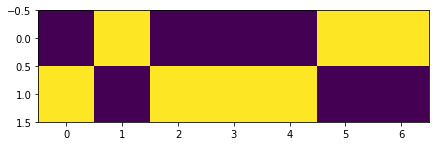

In [3]:
batch, N, C = 3, 7, 2
def show_chain(chain):
    plt.imshow(chain.detach().sum(-1).transpose(0, 1))

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials)
show_chain(dist.argmax[0])

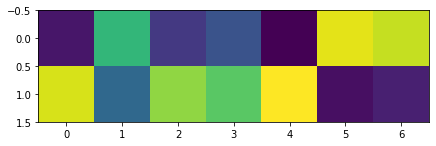

In [4]:
show_chain(dist.marginals[0])

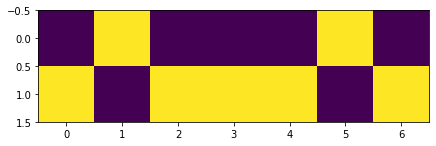

In [5]:
event = dist.to_event(torch.tensor([[0, 1, 0, 1, 1, 1, 0, 1]]), 2)
show_chain(event[0])

## Hidden Markov Model

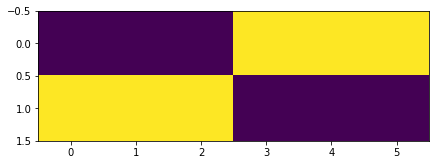

In [6]:
batch, V, N, C = 10, 3, 7, 2

transition = torch.rand(C, C).log_softmax(0)
emission = torch.rand(V, C).log_softmax(0)
init = torch.rand(C).log_softmax(0)
observations = torch.randint(0, V, size=(batch, N))

dist = torch_struct.HMM(transition, emission, init, observations)
show_chain(dist.argmax[0])

## Semi-Markov

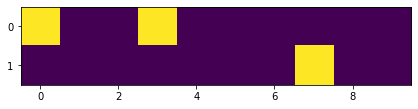

In [7]:
batch, N, C, K = 3, 10, 2, 6
def show_sm(chain):
    plt.imshow(chain.detach().sum(1).sum(-1).transpose(0, 1))

# batch, N, K, z_n, z_n_1
log_potentials = torch.rand(batch, N, K, C, C)
log_potentials[:, :, :3] = -1e9
dist = torch_struct.SemiMarkovCRF(log_potentials)
show_sm(dist.argmax[0])

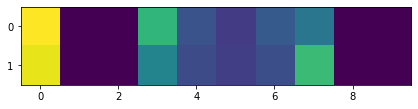

In [8]:
show_sm(dist.marginals[0])

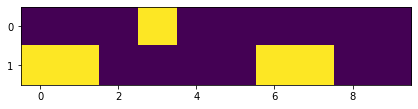

In [9]:
# Use -1 for segments.
event = dist.to_event(torch.tensor([[0, 1, -1, 1, -1, -1, 0, 1,  1, -1, -1]]), (2, 6))
show_sm(event[0])

## Alignment

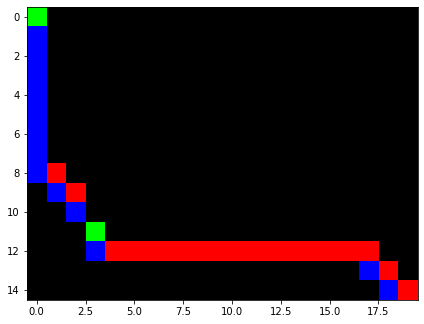

In [10]:
batch, N, M = 3, 15, 20
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, M, 3)
dist = torch_struct.AlignmentCRF(log_potentials)
show_deps(dist.argmax[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


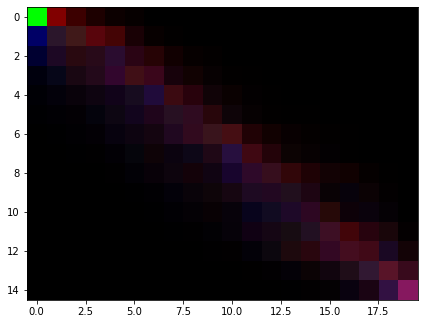

In [11]:
show_deps(dist.marginals[0])

## Dependency Tree

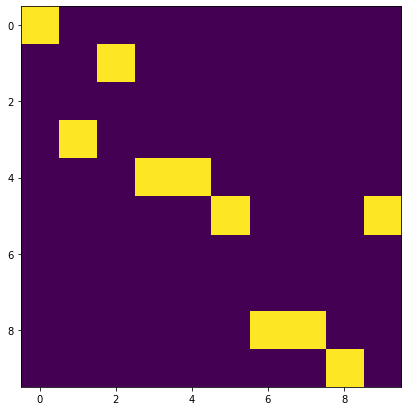

In [12]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, N)
dist = torch_struct.DependencyCRF(log_potentials)
show_deps(dist.argmax[0])

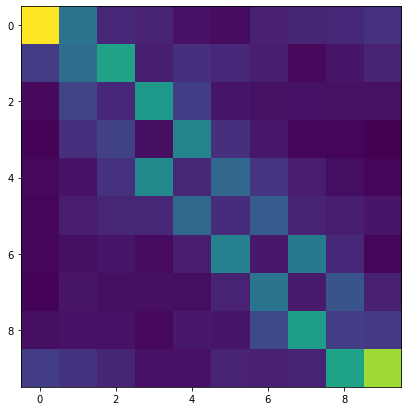

In [13]:
show_deps(dist.marginals[0])

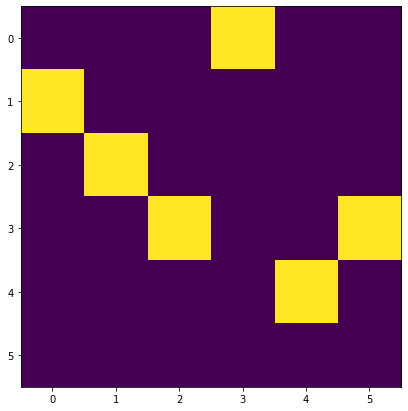

In [14]:
# Convert from 1-index standard format. (Head is 0)
event = dist.to_event(torch.tensor([[2, 3, 4, 1, 0, 4]]), None)
show_deps(event[0])

## Non-Projective Dependency Tree

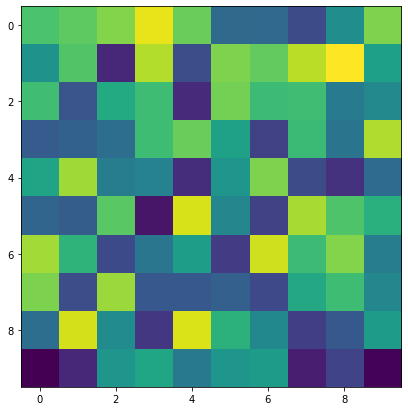

In [15]:
batch, N, N = 3, 10, 10
def show_deps(tree):
    plt.imshow(tree.detach())

log_potentials = torch.rand(batch, N, N)
dist = torch_struct.NonProjectiveDependencyCRF(log_potentials)
show_deps(dist.marginals[0])

## Binary Labeled Tree

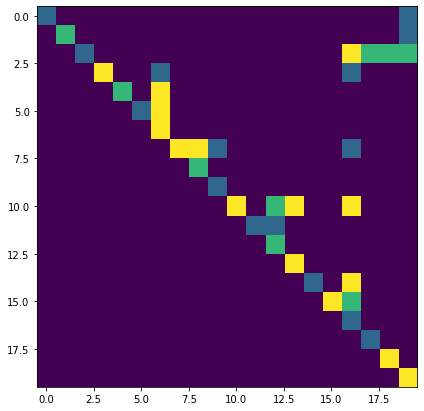

In [16]:
batch, N, NT = 3, 20, 3
def show_tree(tree):
    t = tree.detach()
    plt.imshow(t[ :, : , 0] + 
               2 * t[ :,:, 1] +
               3 * t[ :,:, 2])

log_potentials = torch.rand(batch, N, N, NT)
dist = torch_struct.TreeCRF(log_potentials)
show_tree(dist.argmax[0])

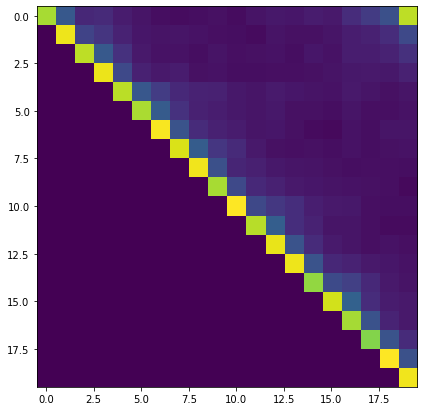

In [17]:
show_tree(dist.marginals[0])

## Probabilistic Context-Free Grammar

In [18]:
?torch_struct.SentCFG

In [19]:
batch, N, NT, T = 3, 20, 3, 3
def show_prob_tree(tree):
    t = tree.detach().sum(-1).sum(-1)
    plt.imshow(t[ :, : , 0] + 
               2 * t[ :,:, 1] +
               3 * t[ :,:, 2])

terminals = torch.rand(batch, N, T)
rules = torch.rand(batch, NT, NT+T,  NT+T)
init = torch.rand(batch, NT).log_softmax(-1)

dist = torch_struct.SentCFG((terminals, rules, init))
term, rules, init = dist.argmax

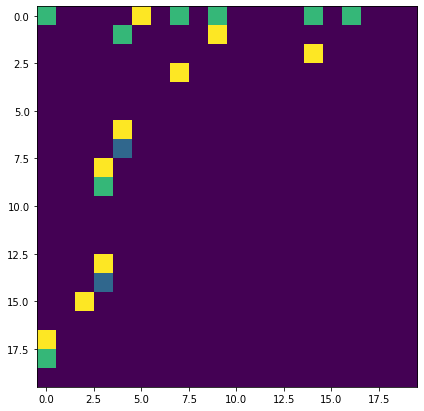

In [20]:
# Rules
show_prob_tree(rules[0])

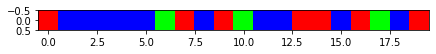

In [21]:
# Terminals
plt.imshow(term[:1])

## Autoregressive / Beam Search

In [38]:
? rnn

In [81]:
batch, N, C, H = 3, 10, 2, 5

rnn = torch.nn.RNN(H, H)
proj = torch.nn.Linear(H, C)
embed = torch.nn.Embedding(C, H)

init = torch.zeros(batch, H)
class AR(torch_struct.AutoregressiveModel):
    def chain(self, state):
        print(state.shape)
        ret =  proj(state)
        print(ret.shape)
        return ret
    def update(self, prev_state, v):
        e = embed(v)
        return rnn(e, prev_state)[1]
    
dist = torch_struct.Autoregressive(AR(), init, C, N)

In [85]:
?torch.nn.RNN

torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])
torch.Size([1, 3, 5])
torch.Size([1, 3, 2])


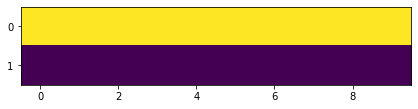

In [82]:
def show_ar(chain):
     plt.imshow(chain.detach().transpose(0, 1))

show_ar(dist.greedy_argmax()[0])

In [83]:
print(dist.beam_topk(5).shape)

torch.Size([5, 3, 5])
torch.Size([5, 3, 2])


RuntimeError: index out of range: Tried to access index 5 out of table with 1 rows. at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:237

## Base Class

In [ ]:
batch, N, C = 3, 7, 2

# batch, N, z_n, z_n_1
log_potentials = torch.rand(batch, N, C, C)
dist = torch_struct.LinearChainCRF(log_potentials, lengths=torch.tensor([N-1, N, N+1]))
show_chain(dist.argmax[0])
plt.show()
show_chain(dist.argmax[1])

In [ ]:
show_chain(dist.marginals[0])
plt.show()
show_chain(dist.marginals[1])

In [ ]:
def show_samples(samples):
    show_chain(samples[0, 0])
    plt.show()
    show_chain(samples[1, 0])
    plt.show()
    show_chain(samples[0, 1])

In [ ]:
show_samples(dist.sample((10,)))

In [ ]:
show_samples(dist.topk(10))

In [ ]:
# Enumerate 
x,_ = dist.enumerate_support()
print(x.shape)
for i in range(10):
    show_chain(x[i][0])
    plt.show()

In [ ]:
plt.imshow(dist.entropy.detach().unsqueeze(0))